In [6]:
from matcalc.relaxation import RelaxCalc
from matcalc.phonon import PhononCalc
from matcalc.eos import EOSCalc
from matcalc.elasticity import ElasticityCalc
from matcalc.util import get_universal_calculator
from datetime import datetime

from pymatgen.ext.matproj import MPRester

In [7]:
mpr = MPRester()

In [3]:
mpdata = mpr.materials._search(nelements=2, fields=["material_id", "structure"])

Retrieving MaterialsDoc documents:   0%|          | 0/20627 [00:00<?, ?it/s]

In [4]:
calc = get_universal_calculator("M3GNet")

/Users/shyue/repos/matgl/matgl/utils/io.py:125: UserWarning: Incompatible model version detected! The code will continue to load the model but it is recommended that you provide a path to an updated model, increment your @model_version in model.json if you are confident that the changes are not problematic, or clear your ~/.matgl cache using `python -c "import matgl; matgl.clear_cache()"`
  _check_ver(cls_, v)  # Check version of any subclasses too.


In [22]:
calculators = [
    ("relax", RelaxCalc(calc)), 
    ("elastic", ElasticityCalc(calc, relax_structure=False)), 
    ("eos", EOSCalc(calc, relax_structure=False)),
    # Note that Phonon usually requires a more stringent fmax criterion and a re-relaxation.
    ("phonon", PhononCalc(calc, relax_structure=True, fmax=0.01)), 
]

In [23]:
data = []

for i, d in enumerate(mpdata):
    s = d.structure
    dd = {"mid": d.material_id, "composition": s.composition.formula, "nsites": len(s)}
    properties = {}
    for name, c in calculators:
        starttime = datetime.now()
        properties[name] = c.calc(s)
        endtime = datetime.now()
        if name == "relax":
            s = properties[name]["final_structure"]
        dd[f"time_{name}"] = (endtime - starttime).total_seconds()
    dd["properties"] = properties
    data.append(dd)
    if i == 10:
        # Here we just do a sampling of 10 structures.
        break

In [24]:
import pandas as pd
df = pd.DataFrame(data)

In [25]:
df

,mid,composition,nsites,time_relax,time_elastic,time_eos,time_phonon,properties
0,mp-1106268,Pr14 Pd6,20,5.672411,0.389471,7.312404,95.785392,{'relax': {'final_structure': [[-5.16210807 2...
1,mp-974315,Ru2 I2,4,1.199593,0.189831,2.191201,2.709812,{'relax': {'final_structure': [[ 1.84401577 -1...
2,mp-1206714,Al2 Sn1,3,0.391959,0.114858,0.248847,0.274779,{'relax': {'final_structure': [[1.59992902 1.5...
3,mp-30339,Er1 Ag2,3,0.146016,0.200051,0.965646,0.808627,{'relax': {'final_structure': [[1.76298403e-08...
4,mp-696,Si4 Pt4,8,1.373731,0.363963,9.206875,20.546138,{'relax': {'final_structure': [[0.90113485 3.8...
5,mp-866222,Ac2 Si6,8,3.997126,0.335380,2.234309,26.709645,{'relax': {'final_structure': [[6.28503045e-07...
6,mp-11422,Gd1 Hg1,2,0.120253,0.109312,0.191998,0.264240,{'relax': {'final_structure': [[-6.87059911e-2...
7,mp-21238,Th4 Si4,8,1.777484,0.223047,3.867465,3.099629,{'relax': {'final_structure': [[1.08682613 0.7...
8,mp-1215363,Zr4 Pd1,5,0.700314,0.189862,2.758254,1.954500,{'relax': {'final_structure': [[ 6.81788689e-0...
9,mp-1212658,Ga1 C6,7,1.530958,0.245652,2.319409,2.941724,{'relax': {'final_structure': [[-1.24073501e-0...


<Axes: xlabel='nsites', ylabel='time_relax'>

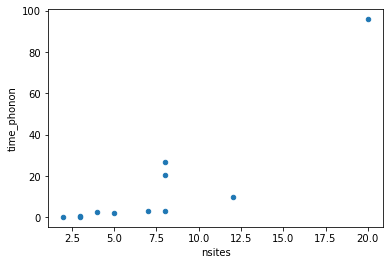

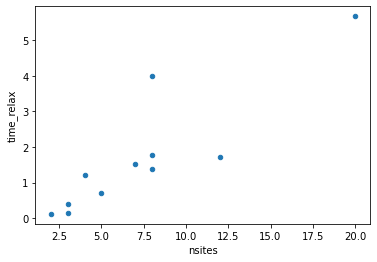

In [30]:
df.plot(x="nsites", y="time_phonon", kind="scatter")
df.plot(x="nsites", y="time_relax", kind="scatter")